This tutorial is generated from a [Jupyter](http://jupyter.org/) notebook that can be found [here](https://github.com/elfi-dev/notebooks).

### Robust Optimisation Monte Carlo (ROMC)

This tutorial provides a foundational overview of ROMC, a likelihood-free inference method. For more information about the theoretical background of the method, you can check [here](http://proceedings.mlr.press/v108/ikonomov20a) and about the implementation details [here](https://givasile.github.io/assets/pdf/edinburgh_thesis.pdf)

**Method Description**

ROMC revolves around the core concept of mapping a stochastic simulator to a set of deterministic functions, denoted as $f_i(\theta)$, by using a different seed. For every $f_i(\theta)$, we aim to identify the optimal parameter set $\mathbf{\theta}_i$, which minimizes the divergence from the observed data $x_0$ as defined by a suitable distance metric:

$$\theta_i^* = argmin_{\theta} \left [ L(f_i(\theta), x_0) \right ], \text{where L is any valid distance}$$

Subsequently, we identify the region $S_i$ around $\theta_i^*$, where the discrepancy with the observed data remains below a specific threshold $ S_i = { \theta \in \mathbb{R}^D: L(f_i(\theta), x_0) \leq \tau }$.

The sum of all these areas $S_i \forall i$ corresponds to the approximate posterior.

---
This tutorial demonstrates how to apply `ROMC` to solve the MA2 problem, which is introduced in the basic tutorial.

In [32]:
import numpy as np
import matplotlib.pyplot as plt
import elfi
from elfi.examples import ma2
import logging

logging.basicConfig(level=logging.INFO)

seed = 1
np.random.seed(seed)
model = ma2.get_model(seed_obs=seed)

# generate and explore some samples 
output = model.generate(batch_size=2, outputs=['t1', 't2', 'MA2', 'S1', 'S2', 'd'])

# and observe the output arrays
print("Shapes of ouputs")
print("th1:     ", output['t1'])
print("th2     :", output['t2'])
print("sum1    :", output['S1'])
print("sum2    :", output['S2'])
print("d       :", output['d'])

Shapes of ouputs
th1:      [-0.1734798   0.50420454]
th2     : [-0.82631129 -0.04356777]
sum1    : [0.10124065 0.31625397]
sum2    : [-0.644445  -0.2650912]
d       : [0.79742933 0.36141145]


### Initialize the ROMC method

The `bounds` argument is not mandatory, yet its inclusion can significantly accelerate the inference process by restricting the exploration of the optimal parameters within a bounding box that encompasses the prior distribution.

In [44]:
# define prior bounds
bounds = [(-2,2), (-2,2)]

# init romc method
romc = elfi.ROMC(model, bounds=bounds, discrepancy_name="d")

### Fitting part

The fitting part has two steps; (a) define and solve the optimization problems and (b) define bounding box regions around the optimal parameters.

#### (a) Solve the optimization problems

The method first transforms the random simulator in a set of deterministic optimization problems and then solves them using either a gradient-based optimizer or with Bayesian Optimization. For this purpose we use:

* `solve_problems(n1, use_bo=False)`: draws `n1` nuisance variables and solves `n1` optimisation problems. If `use_bo=True`, Bayesian Optimization is used instead of a gradient-based optimizer and a Gaussian Process is fitted as a surrogate model of the distance to the observed data.

In [34]:
n1 = 300
seed = 21
romc.solve_problems(n1=n1, seed=seed)

INFO:elfi.methods.inference.romc:### Solving problems using a gradient-based method ###


Solving gradients
Progress [==================================================] 100.0% Complete


INFO:elfi.methods.inference.romc:Time: 96.154 sec
INFO:elfi.methods.inference.romc:Time: 96.154 sec


#### Inspect the optimal distances

Step (b), i.e., finding the bounding box regions, requires setting a cutoff threshold. To gain a better understanding of this threshold, it is helpful to plot the histogram of the optimal distances $d^*$:

* `theta_hist(**kwargs)`: plots a histogram of the distances $d_i^* = L(f_i(\theta_i^*), x_0)$. Inspecting, this histogram is a good indicator for deciding the threshold `eps_filter` before calling `estimate_regions()`.

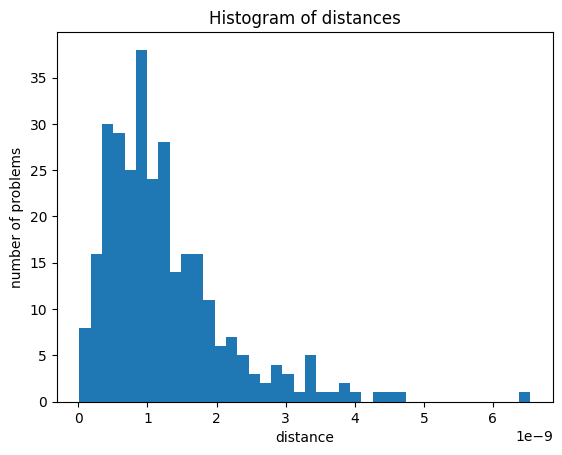

In [35]:
# get the histogram of the optimal points
romc.distance_hist(bins=40)

#### Build bounding boxes around optimal parameters

Step (b) involves building bounding box regions around the optimal parameters $\theta_i^*$:

* `estimate_regions(eps_filter, fit_models, eps_cutoff)`: 

`eps_filter` is the acceptance threshold, i.e., optimal distances $d_i$ over this threshold are discarded. For the optimal distances that fulfil this requirement, the method builds a bounding box s.t. $d_i(\theta) < $ `eps_cutoff`. Finally, if `fit_models=True`, it fits a helping quadratic model of the distance around the optimal point. 

Given the histogram above, some reasonable values are: `eps_filter=0.2` and `eps_cutoff=0.01`.

In [36]:
# estimate bounding box regions
eps_filter = .02
eps_cutoff = .01
romc.estimate_regions(eps_filter=eps_filter, fit_models=True, eps_cutoff=eps_cutoff)

INFO:elfi.methods.inference.romc:Total solutions: 300, Accepted solutions after filtering: 300
INFO:elfi.methods.inference.romc:### Estimating regions ###



Building boxes
Progress [==================================================] 100.0% Complete


INFO:elfi.methods.inference.romc:Time: 44.629 sec 

INFO:elfi.methods.inference.romc:### Fitting local models ###



Fitting models
Progress [==================================================] 100.0% Complete


INFO:elfi.methods.inference.romc:Time: 10.293 sec 



#### Visualize the acceptance regions

* `visualize_region(i)`: plots the area around $\theta_*^{(i)}$, for the i-th optimisation problem. Works only in 1D and 2D parameter spaces.

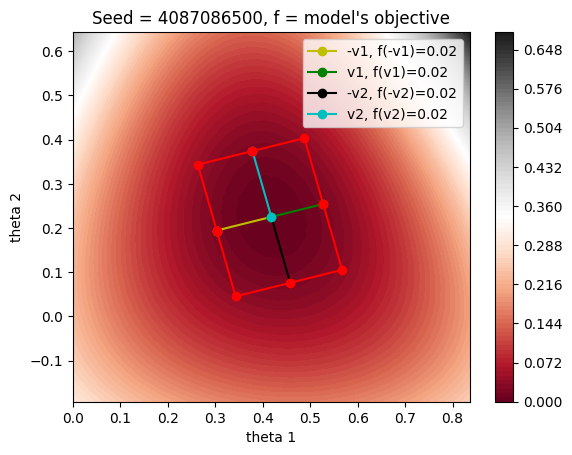

In [37]:
romc.visualize_region(7)

### Inference part

Now that the bounding box are computed, we can use them to draw samples:

* `sample(n2)`: samples `n2` weighted samples per accepted region. In total, we will get $n_1 * n_2$ samples.

* `compute_expectation(h)`: approximates the expected value $E_{P(\theta|data)}[h(\theta)]$ as $\frac{\sum_i h(\theta_i)w_i}{\sum_i w_i}$. `h` can be any callable that accepts a `np.array` of shape `(batch_size, D)` as input

In [38]:
# sample 50 points per accepted region
n2 = 50
romc.sample(n2=n2)

INFO:elfi.methods.inference.romc:### Getting Samples from the posterior ###



Sampling posterior regions


INFO:elfi.methods.inference.romc:Time: 19.110 sec 



Progress [==================================================] 100.0% Complete


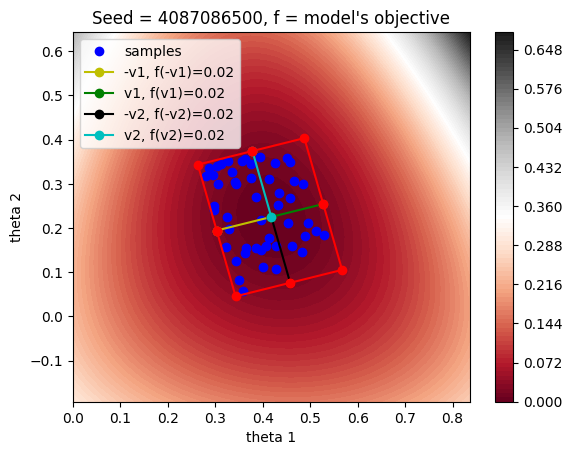

In [26]:
# We can visualize the region as before, now it also plots the samples
romc.visualize_region(7)

### Evaluation Part

Romc provides some functionalities for evaluating the inference

* `romc.result.summary()`: a summary of the posterior samples
* `romc.result.samples_array`: np.array with the posterior samples
* `romc.result.plot_marginals()`: draws the marginal posterior distribution
* `romc.result.sample_means_array`: prints the mean of the posterior samples
* `romc.result.samples_cov()`: prints the covariance of the posterior samples

In [40]:
romc.result.summary()

Method: ROMC
Number of samples: 15000
Parameter                Mean               2.5%              97.5%
t1:                     0.518              0.268              0.788
t2:                     0.074             -0.222              0.428



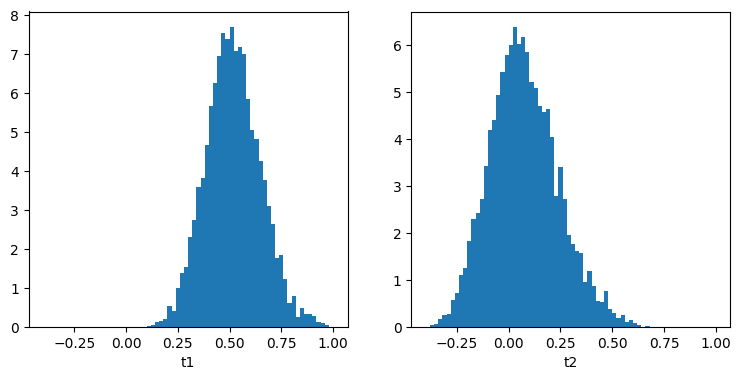

In [41]:
# plot marginal distributions
romc.result.plot_marginals(weights=romc.result.weights, bins=70, range=(-.4, 1))
plt.show()

In [42]:
# print samples mean and covariance
print("Samples mean:")
print(romc.result.sample_means_array)

print("\n")

print("Samples covariance:")
print(romc.result.samples_cov())

Samples mean:
[0.51824262 0.07432631]


Samples covariance:
[[0.01738989 0.00336101]
 [0.00336101 0.02684878]]


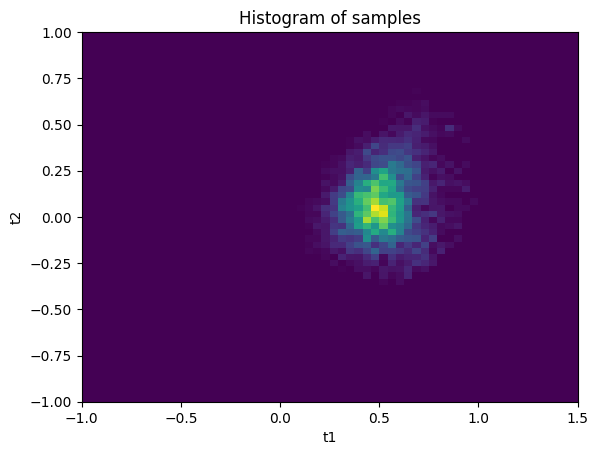

In [43]:
plt.figure()
plt.hist2d(romc.result.samples_array[:,0], romc.result.samples_array[:,1], bins=60, range=[(-1, 1.5), (-1,1)], weights=romc.result.weights)
plt.title("Histogram of samples")
plt.xlabel("t1")
plt.ylabel("t2")
plt.show()

**An Alternative Option: Employing Bayesian Optimization for Optimization**

In the context of ROMC, there exists an alternative approach, which involves the utilization of Bayesian Optimization to tackle the optimization tasks. Opting for this method entails fitting a Gaussian Process surrogate model to approximate the distance. Here are some key points to consider:

* Bayesian Optimization is recommended in cases where approximating gradients is computationally burdensome or when the objective function lacks smoothness, leading to inconsistencies in gradient-based optimization.
* In the Bayesian Optimization setup, the fitting phase may exhibit slower performance (in comparison to scenarios where gradients are readily available). However, the inference phase (such as sampling or evaluating the approximate posterior) benefits from significantly enhanced speed.

To employ Bayesian Optimization, you can execute the following command:

```python
romc.solve_problems(n1=n1, seed=seed, use_bo=True)
```

For the remainder of this notebook, we will adhere to the same procedure as previously outlined.

In this tutorial, we have delved into the fundamental features of the `ROMC` inference method.

For additional illustrative examples, please refer to the following links:

* [Simple 1D example](https://colab.research.google.com/drive/1lGRp0XrNfZ64NN0ASB_tYEKowXwlveDC?usp=sharing)
* [Simple 2D example](https://colab.research.google.com/drive/1Fof_WmCi1YizzSI_63aEsbLXsno5gSZ3?usp=sharing)
* [MA2 example](https://colab.research.google.com/drive/1nkdACQ370SSc0KB1bHv4sBRaxMlMqoNH?usp=sharing)
* [Extending the method example](https://colab.research.google.com/drive/1_jHVxPSH3XcNOORZJpLU0SPzs0PF8CQ5?usp=sharing)
* [Extending the method example (2)](https://colab.research.google.com/drive/1RzB-V1QueP1y1nyzv_VOqR1nVz3DUH3v?usp=sharing)